In [2]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score

import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Part 2 

---
## Part A : Zachary's Karate Club

#### Load karate club graph

In [2]:
G = nx.karate_club_graph()
print("G (Zachary's Karate Club)")
print(G.number_of_nodes(), G.number_of_edges(), G.is_directed())
print('density   :', np.round(nx.density(G), 4))
print('clustering:', np.round(np.mean([e[1] for e in nx.clustering(G).items()]), 4))
print(list(G.edges(data=True))[0:3])

ground_truth = [0, 0, 0, 0, 0, 
                0, 0, 0, 1, 1, 
                0, 0, 0, 0, 1, 
                1, 0, 0, 1, 0, 
                1, 0, 1, 1, 1,
                1, 1, 1, 1, 1,
                1, 1, 1, 1]

G (Zachary's Karate Club)
34 78 False
density   : 0.139
clustering: 0.5706
[(0, 1, {}), (0, 2, {}), (0, 3, {})]


### Try C-Finder, Greedy Modularity Maximization and Louvain

### Louvain

In [3]:
np.round(np.linspace(start=.25,stop=5,num=30), 4)

array([0.25  , 0.4138, 0.5776, 0.7414, 0.9052, 1.069 , 1.2328, 1.3966,
       1.5603, 1.7241, 1.8879, 2.0517, 2.2155, 2.3793, 2.5431, 2.7069,
       2.8707, 3.0345, 3.1983, 3.3621, 3.5259, 3.6897, 3.8534, 4.0172,
       4.181 , 4.3448, 4.5086, 4.6724, 4.8362, 5.    ])

In [3]:
grid = {
    'resolution': np.round(np.linspace(start=.25,stop=5,num=30), 4)
}

results = []
for r in grid['resolution']:

    partition = community_louvain.best_partition(
        G,
        random_state=1,
        resolution=r
    )
    comm_labels = [partition[k] for k in sorted(partition.keys())]

    ## relabel partition labels to be ascending order (to match ground truth)
    labels = []
    for l in comm_labels:
        if l not in labels:
            labels.append(l)
    for i in range(len(comm_labels)):
        comm_labels[i] = labels.index(comm_labels[i])

    accuracy = np.round(sum(np.equal(comm_labels, ground_truth)) / len(ground_truth), 4)
    results.append((r,accuracy,comm_labels))
    
print('best accuracy found at:')
print('resolution\taccuracy')
print(results[np.argmax(results, axis=0)[1]][0], results[np.argmax(results, axis=0)[1]][1], sep='\t\t')

best_comm_labels = results[np.argmax(results, axis=0)[1]][2] ## labels from best result
louvain_comm_labels = best_comm_labels[:]

# draw the graph
# plt.figure(figsize=(8,6))
# nx.draw(G, with_labels=True, node_color=best_comm_labels, cmap='Pastel1', pos=nx.spring_layout(G, seed=7))
# plt.show()

# print('ground truth vs. predicted:')
# for e in list(zip(ground_truth, best_comm_labels)):
#     if e[0] != e[1]:
#         print(e, '**')
#     else:
#         print(e)

best accuracy found at:
resolution	accuracy
1.7241		0.9706


C:\Users\sshepherd\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


### Greedy Modularity Maximization

In [4]:
grid = {
    'resolution': np.round(np.linspace(start=.25,stop=5,num=30), 4)
}

results = []
for r in grid['resolution']:

    partition = nx.community.greedy_modularity_communities(G, resolution=r)
    comm_labels = [None for i in ground_truth]
    for p in partition:
        for pp in p:
            comm_labels[pp] = partition.index(p)

    ## relabel partition labels to be ascending order (to match ground truth)
    labels = []
    for l in comm_labels:
        if l not in labels:
            labels.append(l)
    for i in range(len(comm_labels)):
        comm_labels[i] = labels.index(comm_labels[i])

    accuracy = np.round(sum(np.equal(comm_labels, ground_truth)) / len(ground_truth), 4)
    results.append((r,accuracy,comm_labels))
    
print('best accuracy found at:')
print('resolution\taccuracy')
print(results[np.argmax(results, axis=0)[1]][0], results[np.argmax(results, axis=0)[1]][1], sep='\t\t')

best_comm_labels = results[np.argmax(results, axis=0)[1]][2] ## labels from best result
gmm_comm_labels = best_comm_labels[:]

# draw the graph
# plt.figure(figsize=(8,6))
# nx.draw(G, with_labels=True, node_color=gmm_comm_labels, cmap='Pastel1', pos=nx.spring_layout(G, seed=7))
# plt.show()

# print('ground truth vs. predicted:')
# for e in list(zip(ground_truth, best_comm_labels)):
#     if e[0] != e[1]:
#         print(e, '**')
#     else:
#         print(e)

best accuracy found at:
resolution	accuracy
0.4138		0.9706


### C-Finder

#### Critical density analysis

In [5]:
def _critical_density(k, n):
    return ( (k - 1) * n ) ** ( -1 / (k - 1) )

In [6]:
print('Graph density:', np.round(nx.density(G), 4))

n = len(ground_truth)
ks = list(range(2,10))
print('\nk\tcritical density')
for k in ks:
    print(k, _critical_density(k, n), sep='\t')

Graph density: 0.139

k	critical density
2	0.029411764705882353
3	0.12126781251816648
4	0.2140260367236655
5	0.29282980137146974
6	0.35802241335294416
7	0.4121560116289286
8	0.45760315083162223
9	0.4962252817548962


Based on critical density analysis, we should use k = 4

In [21]:
grid = {
    'k': [4]
}

results = []
for k in grid['k']:

    partition = nx.community.k_clique_communities(G, k=k)
    partition = list(partition)
    comm_labels = [None for i in ground_truth]
    
    label_counts = {}
    for p in partition:
        for pp in p:
            comm_labels[pp] = partition.index(p)
            if pp not in label_counts.keys():
                label_counts[pp] = 1
            else:
                label_counts[pp] += 1
                
    for pp in label_counts.keys():
        if label_counts[pp] > 1:
            comm_labels[pp] = len(partition)

    ## relabel partition labels to be ascending order (to match ground truth)
#     labels = []
#     for l in comm_labels:
#         if l not in labels:
#             labels.append(l)
#     for i in range(len(comm_labels)):
#         comm_labels[i] = labels.index(comm_labels[i])

    accuracy = np.round(sum(np.equal(comm_labels, ground_truth)) / len(ground_truth), 4)
    results.append((k,accuracy,comm_labels))
    
#print('best accuracy found at:')
print('k:', results[np.argmax(results, axis=0)[1]][0])

best_comm_labels = results[np.argmax(results, axis=0)[1]][2] ## labels from best result
#cfinder_comm_labels = best_comm_labels[:]

# # draw the graph
# plt.figure(figsize=(8,6))
# nx.draw(G, with_labels=True, node_color=cfinder_comm_labels, cmap='Pastel1', pos=nx.spring_layout(G, seed=7))
# plt.show()

#print(partition)
#print(best_comm_labels)

# print('ground truth vs. predicted:')
# for e in list(zip(ground_truth, best_comm_labels)):
#     if e[0] != e[1]:
#         print(e, '**')
#     else:
#         print(e)

for i in range(len(comm_labels)):
    if comm_labels[i] == None:
        comm_labels[i] = -1

labels = {}
for i in range(len(comm_labels)):
    if comm_labels[i] == -1:
        labels[i] = 'x'
        
multiple_comms = {}
for k in label_counts.keys():
    if label_counts[k] > 1:
        multiple_comms[k] = label_counts[k]
        
cfinder_comm_labels = comm_labels[:]

k: 4


#### Plots

- louvain resolution: 1.7241
- gmm resolution: .4138
- c-finder k = 4

Ground Truth:


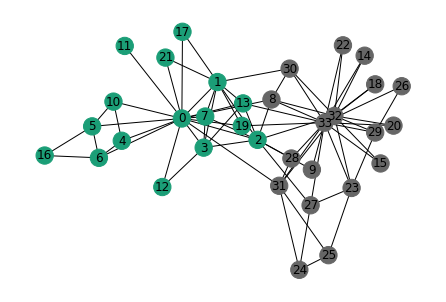

Louvain:


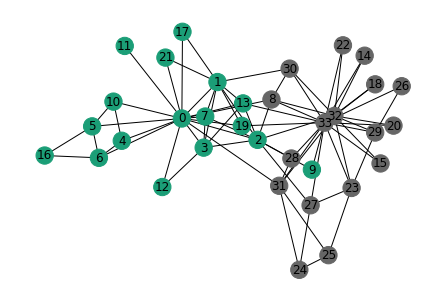

Greedy Modularity Maximization:


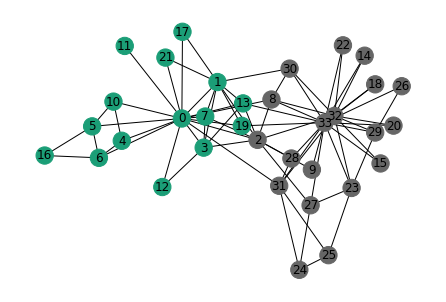

C-Finder:


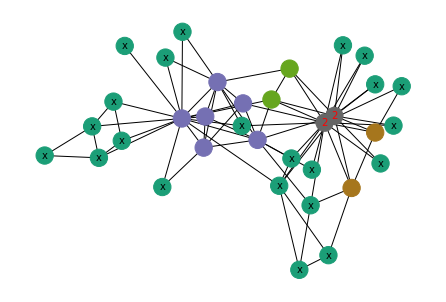

In [23]:
# Ground truth
print('Ground Truth:')
plt.figure(figsize=(6,4))
nx.draw(G, with_labels=True, node_color=ground_truth, cmap='Dark2', pos=nx.spring_layout(G, seed=7))
plt.show()

# Louvain
print('Louvain:')
plt.figure(figsize=(6,4))
nx.draw(G, with_labels=True, node_color=louvain_comm_labels, cmap='Dark2', pos=nx.spring_layout(G, seed=7))
plt.show()

# GMM
print('Greedy Modularity Maximization:')
plt.figure(figsize=(6,4))
nx.draw(G, with_labels=True, node_color=gmm_comm_labels, cmap='Dark2', pos=nx.spring_layout(G, seed=7))
plt.show()

# C-Finder
print('C-Finder:')
plt.figure(figsize=(6,4))
nx.draw(G, with_labels=False, node_color=cfinder_comm_labels, cmap='Dark2', pos=nx.spring_layout(G, seed=7))
nx.draw_networkx_labels(G,nx.spring_layout(G, seed=7),labels,font_size=10,font_color='black')
nx.draw_networkx_labels(G,nx.spring_layout(G, seed=7),multiple_comms,font_size=10,font_color='red')
plt.show()

Nodes 0 and 31 were assigned to multiple communities with k=4.  This appears to be because (at k = 4), their triangle k-cliques are adjacent to others (share k-1 = 3 edges) that are in other communities.  Nodes 9 and 11 were not assigned to any community.

---
## Part B

### B.a

#### Functions given in the notebook

In [154]:
# Generating the LFR Benchmark Network
def generate_network(mu,i):
    n = 500
    tau1 = 2.5
    tau2 = 2
    G = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=5, min_community=40, seed=10)
    communities = {frozenset(G.nodes[v]['community']) for v in G}
    return G, communities

def normalized_mutual_information(a,b):
    # Fill this portion with the code for NMI, Do not use any library for directly computing NMI, 
    # You are free to use math functions from the math library
    
    ## contingency table
    ct = (
        pd.DataFrame(data={'a':a, 'b':b, 'count':[1 for i in a]})
        .pivot_table(index='a', columns='b', values='count', aggfunc='sum')
        .fillna(0)
        .astype(int)
    )
    ct = ct / ct.sum().sum() # convert to probabilities

    mis  = []
    ents = []

    for i in range(len(a)):
        aa = a[i]
        bb = b[i]

        ## mutual information
        jp = ct.loc[aa,bb] # joint prob
        pa = ct.loc[aa].sum() # prob of being element a
        pb = ct.loc[:,bb].sum() # prob of being element b

        mi = jp * math.log( ( jp / (pa * pb) ), 2) # mutual info

        mis.append(mi)

        ## entropy
        enta = pa * math.log(pa, 2)
        entb = pb * math.log(pb, 2)

        ents.append((enta,entb))

    mi = sum(mis) ## aggregate to get mutual information

    ## entropy aggregation/calculation
    enta = -1 * sum(e[0] for e in ents)
    entb = -1 * sum(e[1] for e in ents)
    ent = .5 * (enta + entb)

    nmi = mi / ent

    return nmi

#### Generate LFR Benchmark graph

Graph summary:
500 1478 False
density   : 0.0118
clustering: 0.239

Communities from LFR generator:
this many communities: 8


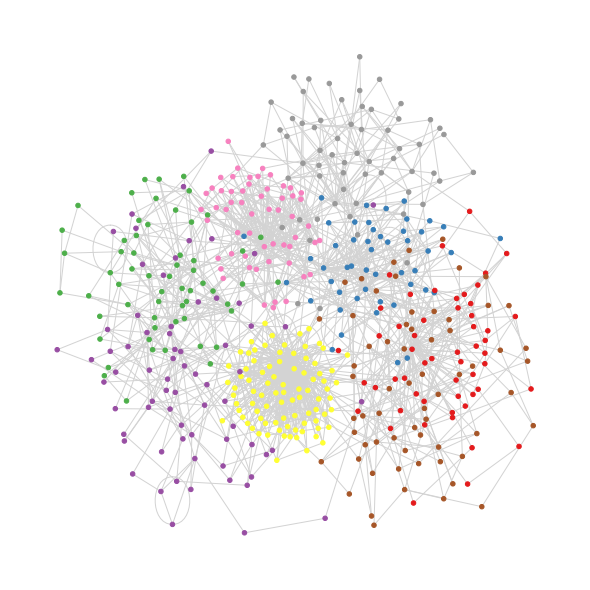

In [27]:
# Write the code for part B here
mu = .1
i  = 0
G, comms = generate_network(mu,i)
comm_labels = [None for n in range(500)]
for p in comms:
    for pp in p:
        comm_labels[pp] = list(comms).index(p)
        
print('Graph summary:')
print(G.number_of_nodes(), G.number_of_edges(), G.is_directed())
print('density   :', np.round(nx.density(G), 4))
print('clustering:', np.round(np.mean([e[1] for e in nx.clustering(G).items()]), 4))

print('\nCommunities from LFR generator:')
print('this many communities:', len(set(comm_labels)))
plt.figure(figsize=(8,8))
nx.draw(G, with_labels=False, node_size=20, node_color=comm_labels, edge_color='lightgray', cmap='Set1',
        pos=nx.kamada_kawai_layout(G))

#### Critical Density threshold analysis for C-Finder

In [29]:
print('Graph density:', np.round(nx.density(G), 4))

n = 500
ks = list(range(2,10))
print('\nk\tcritical density')
for k in ks:
    print(k, _critical_density(k, n), sep='\t')

Graph density: 0.0118

k	critical density
2	0.002
3	0.03162277660168379
4	0.0873580464736299
5	0.14953487812212204
6	0.20912791051825463
7	0.26331754106983357
8	0.31167686372323494
9	0.3546030780581206


So, with a graph density of 0.118, we should choose k=3 and not k=2 as 0.118 is more than .002 (k=2) but less than 0.0316 (k=3)

#### Plots

Communities from Louvain:
this many communities: 9


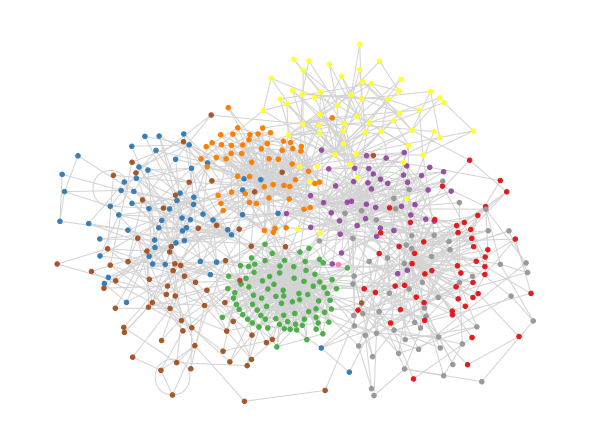

Communities from Greedy Modularity Maximization:
this many communities: 9


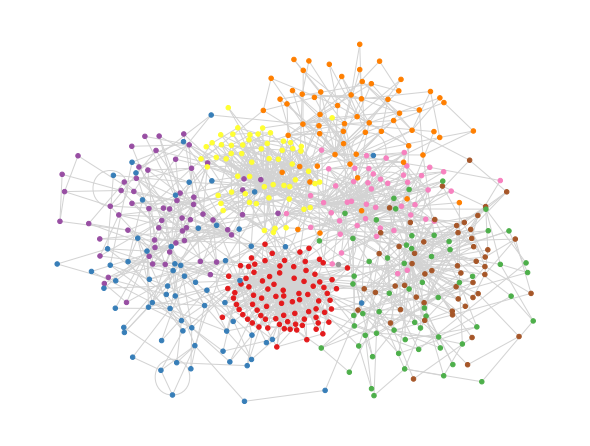

Communities from C-Finder:
this many communities: 34
nodes not in a community marked x
nodes in multiple communities marked in red (# of communities)


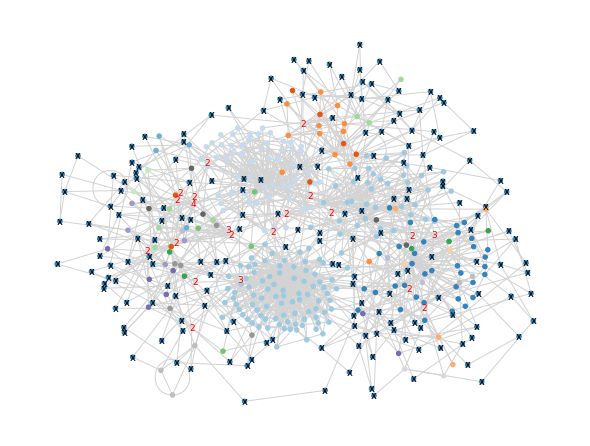

In [32]:
print('Communities from Louvain:')
partition = community_louvain.best_partition(G, random_state=1) ## per Piazza, can use default hyperparameter(s)
comm_labels = [partition[k] for k in sorted(partition.keys())]
print('this many communities:', len(set(comm_labels)))

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=False, node_size=20, node_color=comm_labels, edge_color='lightgray', cmap='Set1',
        pos=nx.kamada_kawai_layout(G))
plt.show()

print('Communities from Greedy Modularity Maximization:') ## per Piazza, can use default hyperparameter(s)
partition = nx.community.greedy_modularity_communities(G)
print('this many communities:', len(partition))
comm_labels = [None for i in range(500)]
for p in partition:
    for pp in p:
        comm_labels[pp] = partition.index(p)

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=False, node_size=20, node_color=comm_labels, edge_color='lightgray', cmap='Set1',
        pos=nx.kamada_kawai_layout(G))
plt.show()

print('Communities from C-Finder:')
k = 3
partition = nx.community.k_clique_communities(G, k=k)
partition = list(partition)
print('this many communities:', len(partition))
comm_labels = [None for i in range(500)]
print('nodes not in a community marked x')
print('nodes in multiple communities marked in red (# of communities)')

label_counts = {}
for p in partition:
    for pp in p:
        comm_labels[pp] = partition.index(p)
        if pp not in label_counts.keys():
            label_counts[pp] = 1
        else:
            label_counts[pp] += 1

for pp in label_counts.keys():
    if label_counts[pp] > 1:
        comm_labels[pp] = len(partition)
        
for i in range(len(comm_labels)):
    if comm_labels[i] == None:
        comm_labels[i] = -1

plt.figure(figsize=(8,6))
nx.draw(G, with_labels=False, node_size=20, node_color=comm_labels, edge_color='lightgray', cmap='tab20c',
        pos=nx.kamada_kawai_layout(G))

labels = {}
for i in range(len(comm_labels)):
    if comm_labels[i] == -1:
        labels[i] = 'x'
        
multiple_comms = {}
for k in label_counts.keys():
    if label_counts[k] > 1:
        multiple_comms[k] = label_counts[k]
        
nx.draw_networkx_labels(G,nx.kamada_kawai_layout(G),labels,font_size=10,font_color='black')
nx.draw_networkx_labels(G,nx.kamada_kawai_layout(G),multiple_comms,font_size=9,font_color='red')
plt.show()

### B.b

<AxesSubplot:title={'center':'Normalized Mutual Information: Community Algorithm vs. Ground Truth'}, xlabel='mu'>

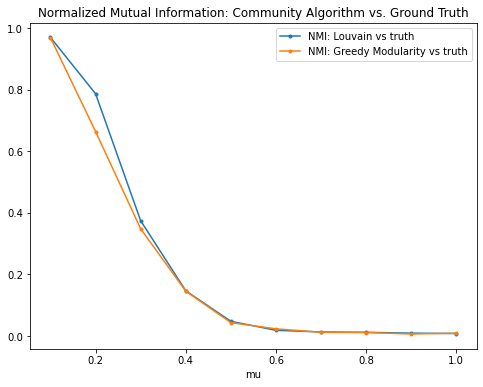

In [177]:
mus = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

results = []

for i in range(len(mus)):
    
    ## LFR Generate
    mu = mus[i]
    G, comms = generate_network(mu,i)
    comm_labels = [None for n in range(500)]
    for p in comms:
        for pp in p:
            comm_labels[pp] = list(comms).index(p)
    #print('lfr ground truth communities:', len(set(comm_labels)))
            
    ## Louvain
    partition = community_louvain.best_partition(G, random_state=1) ## per Piazza, can use default hyperparameter(s)
    louvain_labels = [partition[k] for k in sorted(partition.keys())]
    #print('louvain communities:', len(set(louvain_labels)))

    ## Greedy Modularity Maximization
    partition = nx.community.greedy_modularity_communities(G)
    #print('gmm communities:', len(partition))
    gmm_labels = [None for i in range(500)]
    for p in partition:
        for pp in p:
            gmm_labels[pp] = partition.index(p)
    
    results.append((
        mu,
        normalized_mutual_information(comm_labels,louvain_labels),
        normalized_mutual_information(comm_labels,gmm_labels)
    ))
    
(
    pd.DataFrame.from_records(results, columns=['mu','NMI: Louvain vs truth','NMI: Greedy Modularity vs truth'])
    .set_index('mu')
    .plot(kind='line', style='.-', figsize=[8,6], title='Normalized Mutual Information: Community Algorithm vs. Ground Truth')
)

---
## Part C

Real world graphs

#### Load the graphs

In [178]:
G1 = nx.read_edgelist('./yeast.txt', nodetype=int,data=(('weight',float),))
G2 = nx.read_edgelist('./US_airports.txt', nodetype=int,data=(('weight',float),))

#g1 = nx.read_weighted_edgelist('./yeast.txt')
#g2 = nx.read_weighted_edgelist('./US_airports.txt')

print('G1 (yeast)')
print(G1.number_of_nodes(), G1.number_of_edges(), G1.is_directed(), np.round(nx.density(G1), 4))
print('density:', np.round(np.mean([e[1] for e in nx.clustering(G1).items()]), 4))
print(list(G1.edges(data=True))[0:3])

print('\nG2 (airports)')
print(G2.number_of_nodes(), G2.number_of_edges(), G2.is_directed(), np.round(nx.density(G2), 4))
print('density:', np.round(np.mean([e[1] for e in nx.clustering(G2).items()]), 4))
print(list(G2.edges(data=True))[0:3])

G1 (yeast)
688 1078 False 0.0046
density: 0.0472
[(1, 194, {'weight': 1.0}), (1, 199, {'weight': 1.0}), (194, 77, {'weight': 1.0})]

G2 (airports)
1574 17215 False 0.0139
density: 0.5042
[(1, 47, {'weight': 9.0}), (1, 832, {'weight': 7.0}), (47, 6, {'weight': 9.0})]


#### Community Detection

Graph 1 (yeast)


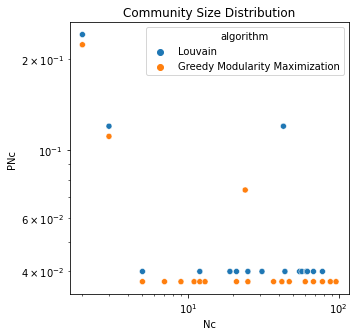

Graph 2 (airports)


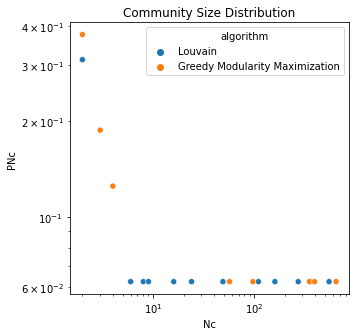

In [353]:
cnt = 0
for g in [G1,G2]:
    if cnt == 0:
        print("Graph 1 (yeast)")
    else:
        print("Graph 2 (airports)")
    cnt += 1

    ## Louvain
    partition = community_louvain.best_partition(g, random_state=1) ## per Piazza, can use default hyperparameter(s)
    louvain_labels = [partition[k] for k in sorted(partition.keys())]
    #print('louvain communities:', len(set(louvain_labels)))

    louvain_sizes = {}
    for l in sorted(list(set(louvain_labels))):
        cnt = 0
        for ll in louvain_labels:
            if ll == l:
                cnt += 1
        if cnt not in louvain_sizes.keys():
            louvain_sizes[cnt] = 1 / len(set(louvain_labels))
        else:
            louvain_sizes[cnt] += 1 / len(set(louvain_labels))

    ## Greedy Modularity Maximization
    partition = nx.community.greedy_modularity_communities(g)
    #print('gmm communities:', len(partition))
    gmm_labels = {}
    for p in partition:
        for pp in list(p):
            gmm_labels[pp] = partition.index(p)

    gmm_labels_list = []
    for k in sorted(gmm_labels.keys()):
        gmm_labels_list.append(gmm_labels[k])

    gmm_labels = gmm_labels_list[:]

    gmm_sizes = {}
    for p in partition:
        if len(p) not in gmm_sizes.keys():
            gmm_sizes[len(p)] = 1 / len(partition)
        else:
            gmm_sizes[len(p)] += 1 / len(partition)

    ls = (
        pd.DataFrame.from_dict(louvain_sizes, orient='index', columns=['PNc'])
        .reset_index()
        .rename(columns={'index':'Nc'})
        .sort_values(by='Nc')
    )
    ls['algorithm'] = 'Louvain'

#     (
#         ls
#         .plot(kind='scatter', x='Nc', y='PNc', loglog=True, title='Louvain - Community Size Distribution')
#     )
#     plt.show()

    gmms = (
        pd.DataFrame.from_dict(gmm_sizes, orient='index', columns=['PNc'])
        .reset_index()
        .rename(columns={'index':'Nc'})
        .sort_values(by='Nc')
    )
    gmms['algorithm'] = 'Greedy Modularity Maximization'

    for_plot = pd.concat((ls,gmms))
    f, ax = plt.subplots(figsize=(5,5))
    ax.set(xscale="log", yscale="log", title="Community Size Distribution")
    sns.scatterplot(x="Nc", y="PNc", data=for_plot, hue="algorithm")
    plt.show()

---
## Part 3

(did not complete Part 3)

# END

In [355]:
! conda list -e > requirements.txt